In [3]:
import requests
import json

# documentation at https://www.yelp.com/developers/documentation/v3/authentication
api_key = "YOUR API KEY HERE"
headers = {"Authorization": "Bearer " + api_key}
    
def get_place_id(search_term):
    # documentation at https://www.yelp.com/developers/documentation/v3/business_search
    url = "https://api.yelp.com/v3/businesses/search"
    url += "?term=" + search_term
    # GU GPS coords
    url += "&latitude=47.6670357"
    url += "&longitude=-117.403623"
    
    response = requests.get(url=url, headers=headers)
    json_object = json.loads(response.text)

    place_id = json_object["businesses"][0]["id"]
    print(search_term, "id:", place_id)
    
    return place_id
    
def get_reviews(search_term):
    # documentation at https://www.yelp.com/developers/documentation/v3/business_reviews
    # returns three reviews in yelp "default order"
    place_id = get_place_id(search_term)
    url = "https://api.yelp.com/v3/businesses/" + place_id + "/reviews"
    response = requests.get(url=url, headers=headers)
    json_object = json.loads(response.text)
    reviews_array = json_object["reviews"]
    reviews_text = []
    for review_object in reviews_array:
        reviews_text.append(review_object["text"])
    return reviews_text

reviews_dict = {"qdoba": get_reviews("qdoba"), "tastybun": get_reviews("tastybun")}

qdoba id: OCfzLnNHvsPEstRioJ8kQw
tastybun id: xqeK-0nESL8Tv_pkSal0AA


In [4]:
for name, reviews in reviews_dict.items():
    print("***",name, "reviews", "***")
    for review in reviews:
        print("\t", review)
    print()

*** qdoba reviews ***
	 I recently ordered through UberEats and the delivery driver failed to get all of the bags from QDOBA.   I called the restaurant to find out why we were...
	 The best mexican food I have eaten in Spokane. Ok. Best I have eaten in texas. Big portions. Great prices. Love they don't drizzle on the flan. Delicious....
	 I wish I could give 0 stars. I would suggest avoiding this location at all costs. I placed an online order for pick up at 1215 and had my friend place an...

*** tastybun reviews ***
	 If you don't know what to eat or where to eat, come here! Super taste easy eat!!! The buns are moist and the flavor is just right, not too salt not too...
	 Ehhhhhh....lack luster food......very disappointed in the ingredients and the taste. No originality, this was thrown together and everything is stale
	 Like many, I have been dreaming of real fresh steamed buns!   Today's off-menu surprise was chicken Teriyaki.  Buns made fresh every day!  Soup too!!!!   I...



## Task 1
Compute the average polarity of the reviews. Does this seem in line with the average rating for each business?
* Qdoba average rating: ~3.5
    * https://www.yelp.com/biz/qdoba-mexican-eats-spokane-2
* Tasty Bun average rating: ~4.5
    * https://www.yelp.com/biz/tasty-bun-spokane

In [5]:
from textblob import TextBlob

def compute_average_polarity(reviews):
    polarities = []
    for review in reviews:
        blob = TextBlob(review)
        for sentence in blob.sentences:
            polarities.append(sentence.sentiment.polarity)
    return sum(polarities) / len(polarities)

for name, reviews in reviews_dict.items():
    avg_polarity = compute_average_polarity(reviews)
    print(name, "avg polarity:", avg_polarity)

qdoba avg polarity: 0.3227272727272727
tastybun avg polarity: -0.006819196428571417


## Task 2
Visualize the frequencies of words in both sets of business reviews with word clouds using `wordcloud` module. Do the most frequent words in each provide more context for your polarity result?

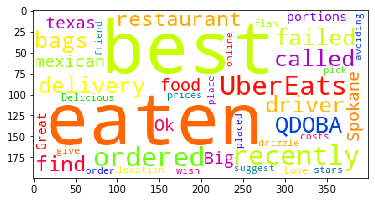

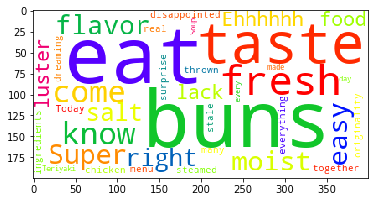

In [7]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def show_wordcloud(name, text):
    plt.figure() # wordlcloud library is built on matplotlib
    word_cloud = WordCloud(colormap="prism", background_color="white")
    # note: wordcloud removes "stop" words from the text
    # word that lack useful info, like "a", "an", "the", "you", etc.
    word_cloud = word_cloud.generate(text)
    plt.imshow(word_cloud)
    
for name, reviews in reviews_dict.items():
    reviews_str = " ".join(reviews)
    show_wordcloud(name, reviews_str)

## Task 3
Compute readability scores for each set of reviews using `textatistic` module. Compare the Dale-Chall scores, which is a score that can be mapped to grade levels from 4 and below to college graduate (grade 16) and above. This score is considered to be most reliable for a broad range of text types.

What can these scores be used for? (with the small sample size we have we can't make any definitive conclusions...)

In [9]:
from textatistic import Textatistic

def print_readability_scores(name, text):
    print("*****", name, "*****")
    readability = Textatistic(text)
    for stat, value in readability.dict().items():
        print(stat, ":", value)
        
for name, reviews in reviews_dict.items():
    reviews_str = " ".join(reviews)
    print_readability_scores(name, reviews_str)

***** qdoba *****
char_count : 380
word_count : 88
sent_count : 19
sybl_count : 105
notdalechall_count : 18
polysyblword_count : 4
flesch_score : 101.19076555023923
fleschkincaid_score : 0.2958612440191395
gunningfog_score : 3.670813397129187
smog_score : 5.7502877580894305
dalechall_score : 7.095999043062202
***** tastybun *****
char_count : 381
word_count : 78
sent_count : 28
sybl_count : 102
notdalechall_count : 13
polysyblword_count : 5
flesch_score : 93.3767307692308
fleschkincaid_score : 0.9271978021978029
gunningfog_score : 3.678388278388278
smog_score : 5.543175910156928
dalechall_score : 6.406338095238095


## Task 4
Perform named entity recognition using `spaCy`. What dates, times, quantities, places, people, things, organizations, do people mention in their reviews of these businesses?

In [10]:
import spacy

nlp = spacy.load("en")

for name, reviews in reviews_dict.items():
    print(name)
    reviews_str = " ".join(reviews)
    document = nlp(reviews_str)
    
    for entity in document.ents:
        print(entity.text, "->", entity.label_)
    print()


qdoba
UberEats -> ORG
QDOBA -> ORG
Spokane -> GPE
1215 -> DATE

tastybun
Today -> DATE
Teriyaki -> ORG
Buns -> PERSON



## Task 5
Calculate document similarity using `spaCy` to determine how alike the review sets are in terms of word frequencies, writing styles, etc. Do you hypothesize there are other businesses (but still in this category) that would have reviews that are more or less similar to these? Test your theories out with the API and `spaCy` :)

In [12]:
document1 = nlp(" ".join(reviews_dict["qdoba"]))
document2 = nlp(" ".join(reviews_dict["tastybun"]))
print(document1.similarity(document2)) # ~83.55% similarity

# note see today's notes on github for how to resolve the warning below

0.8365824346368361


/Users/sprint/opt/anaconda3/lib/python3.7/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  "__main__", mod_spec)
